SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [1]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 27 # for MLS only
target_col = 'points'
ignore_cols = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled', 'games_played', 'round']
sub_cols = ['current_formation', 'avg_goals_against', 'goal_diff', 'win_percentage', 'sos',
           'opp_win_percentage', 'opp_sos', 'current_team_yellow_cards', 'current_team_corner_kicks', 'current_team_first_half_goals', 'current_team_sec_half_goals', 
           'opp_team_yellow_cards', 'opp_team_corner_kicks', 'opp_team_first_half_goals', 'opp_team_sec_half_goals']

all_models = ['log', 'svc', 'gmm', 'knn', 'gnb', 'randomForest']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


In [2]:
data_csv = 'round' + str(round_number) + '.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)
print('Data Loaded...')
print("Dataset size :: {}".format(raw_data.shape))
display(raw_data.head())

Data Loaded...
Dataset size :: (614, 57)


,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,goal_efficiency,win_percentage,sos,rpi,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,opp_win_percentage,opp_sos,opp_rpi,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_cards,current_team_corner_kicks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_first_half_goals,current_team_sec_half_goals,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_yellow_cards,opp_team_corner_kicks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_first_half_goals,opp_team_sec_half_goals,opp_team_goal_kicks,goals,points
0,249,21,FC Dallas,33,DC United,2016-03-26 21:30:00,4,3,0,4-2-3-1,2.000000,1.333333,1.666667,-0.333333,-1,0.117647,0.666667,0.619048,0.630952,1.000000,2.000000,0.666667,0.000000,0.714286,0.517544,0.477444,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,2.000000,6.666667,6.666667,11.666667,85.333333,11.666667,1.666667,0.333333,1.000000,5.666667,48.666667,113.666667,45.333333,1.000000,2.333333,5.333333,8.666667,112.333333,8.666667,4.333333,0.666667,1.333333,8.666667,3,3
1,255,21,FC Dallas,39,Columbus Crew,2016-04-03 01:00:00,5,3,1,4-4-2,2.000000,1.666667,1.666667,0.000000,0,0.333333,0.714286,0.383130,0.465919,0.333333,0.333333,-1.000000,0.000000,0.312500,0.487421,0.407233,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,2.333333,4.666667,5.666667,10.666667,94.666667,10.666667,1.666667,0.666667,1.000000,5.333333,47.666667,110.666667,60.000000,2.333333,4.333333,2.333333,7.666667,108.666667,7.666667,1.666667,0.000000,0.333333,9.000000,1,1
2,265,21,FC Dallas,32,San Jose Earthquakes,2016-04-10 01:00:00,6,3,1,4-4-2,2.333333,2.000000,0.333333,1.666667,5,0.052632,0.833333,0.452519,0.547723,0.333333,0.666667,-0.333333,0.166667,0.312500,0.441520,0.456140,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,2.000000,3.333333,6.333333,15.000000,95.333333,15.000000,3.000000,0.666667,1.333333,5.666667,54.000000,97.666667,57.000000,0.333333,6.000000,6.333333,10.666667,93.000000,10.666667,2.666667,0.333333,0.333333,9.000000,2,1
3,272,21,FC Dallas,30,Portland Timbers,2016-04-14 02:30:00,7,3,0,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,1.000000,1.333333,-0.666667,0.285714,0.357143,0.645906,0.573715,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,3,3
4,282,21,FC Dallas,27,Sporting Kansas City,2016-04-17 23:00:00,7,3,1,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,0.000000,1.333333,-0.666667,0.285714,0.357143,0.490184,0.523888,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,2,3


## FORMATTING

Converting Goals to our binary classification (0-1) and (2+) and also converting the sos and rpi and implementing the team to a particular rpi quartile

In [3]:
# Helper Function - Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

""" Need to do some formatting of the Data before we run the models"""
pd.set_option('display.max_columns', 500)

""" Formatting data to convert goals scored to the correct category"""
# Not using points as a target for this version
formatted_data = raw_data.drop('points', 1)

formatted_data['converted_goals'] = formatted_data.apply(lambda row: model_libs.set_group(row['goals']), axis=1)
print(formatted_data.shape)

""" Setting the RPI Quartiles on the formatted data """
leagues = ["USA", "ENG", "DEU", "ESP", "FRA"]
teams = form_data.get_teams()
              
classifier_data = model_libs.convert_sos_rpi(leagues, formatted_data, teams)
regr_data = classifier_data.copy()
# Drop the original RPI features and everything else
classifier_data = classifier_data.drop(sub_cols + ignore_cols + ['goals'] + ['rpi', 'opp_rpi'], 1)
display(classifier_data.head())

(614, 57)


stats/model_libs.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['rpi_quartiled'] = pd.Series(None, index=data.index)
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

,is_home,avg_points,avg_goals_for,margin,goal_efficiency,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,converted_goals,rpi_quartiled,opp_rpi_quartiled
0,0,2.000000,1.333333,-0.333333,0.117647,1.000000,2.000000,0.666667,0.000000,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,6.666667,11.666667,85.333333,11.666667,1.666667,5.666667,48.666667,113.666667,45.333333,5.333333,8.666667,112.333333,8.666667,4.333333,8.666667,1,1.0000,0.0000
1,1,2.000000,1.666667,0.000000,0.333333,0.333333,0.333333,-1.000000,0.000000,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,5.666667,10.666667,94.666667,10.666667,1.666667,5.333333,47.666667,110.666667,60.000000,2.333333,7.666667,108.666667,7.666667,1.666667,9.000000,0,0.3333,0.0000
2,1,2.333333,2.000000,1.666667,0.052632,0.333333,0.666667,-0.333333,0.166667,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,6.333333,15.000000,95.333333,15.000000,3.000000,5.666667,54.000000,97.666667,57.000000,6.333333,10.666667,93.000000,10.666667,2.666667,9.000000,1,0.6666,0.0000
3,0,1.666667,2.000000,1.000000,0.153846,1.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,1,0.6666,1.0000
4,1,1.666667,2.000000,1.000000,0.153846,0.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,1,0.6666,0.6666


### RUNNING CLASSIFICATION MODEL ON IF TEAMS SCORE 0-1 OR 1-2 ON GAMES

In [6]:
def run_features(data, drop_data, target, models):
    
    new_data = data.drop(drop_data, axis=1)
    
    #display(new_data.head())
    
    (y, X) = model_libs._extract_target(new_data, target)
    
    models = form_model.train_models(round_number, X, y, models)
    
    return models


#### Running ALL Features 
models_test_1 = run_features(classifier_data, [], 'converted_goals', ["knn"])

(classifier_y, classifier_X) = model_libs._extract_target(classifier_data, 'converted_goals')

def check_accuracy(model, data_X):
    actual_y = pd.DataFrame(classifier_y.values, columns=['actual'])
    predictions = pd.DataFrame(model.predict(data_X), columns=['predictions'])
    preds = pd.concat([predictions, actual_y], axis=1)
    preds['diff'] = preds.apply(lambda r: model_libs.predictions_diff(r['predictions'], r['actual']), axis=1)
    accuracy = np.divide(preds['diff'].sum(),float(len(preds['diff'])))
    print(accuracy)

for m in models_test_1:
    check_accuracy(m, classifier_X)

-----------------------------------
Training K Neighbors Classifier Model
KNN Score on Training Set :: 0.788187372709
KNN Score on Test Set:: 0.577235772358
Finished K-Means Modeling
0.745928338762


In [ ]:
def train_tuned_models(round_num, X, y):
    for i in all_models:
        models = form_model.build_tuned_model(X, y, i)
        
    return models
        
tuned_models = train_tuned_models(round_number, classifier_X, classifier_y)

# Optimize Features

In [ ]:
def plot_RFECV(X, y):
    svc = SVC(kernel="linear")
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
                  scoring='accuracy')
    rfecv.fit(X, y)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
plot_RFECV(classifier_X, classifier_y)

In [7]:
def create_RFE(X, y):
    # Create the RFE object and rank each pixel
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit(X, y)
    print(rfe.ranking_)
    return rfe.ranking_

rankings = create_RFE(classifier_X, classifier_y)

[12 15 11 16  9 10  3 27  6  4  7 22 18 26 25 13  1 31  2  8 23 24 28 29 30
 21 32 20 17 14  5 19]


In [8]:
""" Reordering the columns in the data to reflect the rankings """
def rank_columns(data_X, rankings):
    rankings_name = []
    ranked_X = data_X

    for r in range(len(rankings)):
        column_name = data_X.iloc[:, rankings[r]-1].name
        rankings_name.append(column_name)

    ranked_X = ranked_X.reindex_axis(rankings_name, axis=1)
    
    return ranked_X

ranked_X = rank_columns(classifier_X, rankings)
display(ranked_X.head())

,goal_attempts_op_ratio,current_team_dangerous_attacks,ball_safe_op_ratio,current_team_shots_on_target,opp_goal_efficiency,goals_op_ratio,avg_goals_for,opp_team_ball_safe,opp_avg_points,margin,opp_avg_goals,opp_team_possession,current_team_ball_safe,opp_team_shots_total,opp_team_shots_on_target,current_team_possession,is_home,rpi_quartiled,avg_points,opp_margin,opp_team_attacks,opp_team_dangerous_attacks,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,current_team_goal_kicks,opp_rpi_quartiled,current_team_saves,current_team_shots_total,current_team_attacks,goal_efficiency,current_team_goal_attempts
0,1.346154,60.666667,0.759644,6.666667,0.000000,0.666667,1.333333,112.333333,1.000000,-0.333333,2.000000,48.666667,85.333333,8.666667,5.333333,50.333333,0,1.0000,2.000000,0.666667,113.666667,45.333333,8.666667,4.333333,8.666667,5.666667,0.0000,1.666667,11.666667,103.333333,0.117647,11.666667
1,1.391304,56.333333,0.871166,5.666667,0.000000,5.000000,1.666667,108.666667,0.333333,0.000000,0.333333,47.666667,94.666667,7.666667,2.333333,50.666667,1,0.3333,2.000000,-1.000000,110.666667,60.000000,7.666667,1.666667,9.000000,5.333333,0.0000,1.666667,10.666667,112.000000,0.333333,10.666667
2,1.406250,56.000000,1.025090,6.333333,0.166667,3.000000,2.000000,93.000000,0.333333,1.666667,0.666667,54.000000,95.333333,10.666667,6.333333,49.333333,1,0.6666,2.333333,-0.333333,97.666667,57.000000,10.666667,2.666667,9.000000,5.666667,0.0000,3.000000,15.000000,113.000000,0.052632,15.000000
3,2.157895,48.333333,0.957447,5.666667,0.285714,1.500000,2.000000,94.000000,1.000000,1.000000,1.333333,44.666667,90.000000,6.333333,3.666667,51.333333,0,0.6666,1.666667,-0.666667,90.666667,44.666667,6.333333,2.666667,9.666667,5.333333,1.0000,2.666667,13.666667,103.333333,0.153846,13.666667
4,2.157895,48.333333,0.957447,5.666667,0.285714,1.500000,2.000000,94.000000,0.000000,1.000000,1.333333,44.666667,90.000000,6.333333,3.666667,51.333333,1,0.6666,1.666667,-0.666667,90.666667,44.666667,6.333333,2.666667,9.666667,5.333333,0.6666,2.666667,13.666667,103.333333,0.153846,13.666667


In [ ]:
def train_ranked_models(X, y):
    
    for x in xrange(15, 18):
        print('X :: {}'.format(x))

        ranked_models = form_model.train_models(round_number, X.iloc[:, 1:x], y, ['log',  'svc', 'gmm', 'knn', 'gnb', 'randomForest'])
        
train_ranked_models(ranked_X, classifier_y)

In [ ]:
new_models = form_model.train_models(round_number, ranked_X.iloc[:, 1:17], classifier_y, ['log', 'svc', 'knn', 'gnb', 'randomForest'])

for m in new_models:
    check_accuracy(m, ranked_X.iloc[:, 1:17])

In [9]:
random_forest_model = form_model.build_tuned_model(ranked_X.iloc[:, 1:17], classifier_y, 'randomForest')

for m in random_forest_model:
    print(m)
    check_accuracy(m, ranked_X.iloc[:, 1:17])

-----------------------------------
Training Random Forest Model
[ 0.5959596   0.60606061  0.65306122  0.65306122  0.62886598]
Accuracy: 0.63 (+/- 0.05)
Finished Random Forest Modeling
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=2, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.687296416938


In [10]:
knn_model = form_model.build_tuned_model(ranked_X.iloc[:, 1:12], classifier_y, 'knn')

for m in knn_model:
    check_accuracy(m, ranked_X.iloc[:, 1:12])

-----------------------------------
Training K-Means Model
KNN Score :: 0.77800407332 for Training
KNN Score :: 0.577235772358 for Testing
KNN Score :: 0.782077393075 for Training
KNN Score :: 0.552845528455 for Testing
KNN Score :: 0.782077393075 for Training
KNN Score :: 0.577235772358 for Testing
KNN Score :: 0.763747454175 for Training
KNN Score :: 0.585365853659 for Testing
KNN Score :: 0.778455284553 for Training
KNN Score :: 0.549180327869 for Testing
Finished K-Means Modeling
0.732899022801


In [11]:
gnb_model = form_model.build_tuned_model(ranked_X.iloc[:, 1:17], classifier_y, 'gnb')

for m in gnb_model:
    print(m)
    check_accuracy(m, ranked_X.iloc[:, 1:17])

-----------------------------------
Training Gaussian NB Model
[ 0.55555556  0.57575758  0.67346939  0.59183673  0.53608247]
Accuracy: 0.59 (+/- 0.09)
Finished Gaussian NB Modeling
GaussianNB()
0.591205211726


In [12]:
gmm_model = form_model.build_tuned_model(ranked_X.iloc[:, 1:17], classifier_y, 'gmm')

for m in gmm_model:
    print(m)
    check_accuracy(m, ranked_X.iloc[:, 1:17])

-----------------------------------
Training and Tuning GMM Model
W/ Covariance Type :: spherical
# of Components :: 2
Silhouette Score :: 0.227939480819 for Training
Silhouette Score :: 0.300121419592 for Testing
# of Components :: 3
Silhouette Score :: 0.123802202485 for Training
Silhouette Score :: 0.167765340965 for Testing
# of Components :: 4
Silhouette Score :: 0.151339537904 for Training
Silhouette Score :: 0.179772411315 for Testing
W/ Covariance Type :: tied
# of Components :: 2
Silhouette Score :: 0.227705749293 for Training
Silhouette Score :: 0.308075215903 for Testing
# of Components :: 3
Silhouette Score :: 0.0485053179415 for Training
Silhouette Score :: 0.0728366277972 for Testing
# of Components :: 4
Silhouette Score :: 0.0559530535938 for Training
Silhouette Score :: 0.00767045795254 for Testing
W/ Covariance Type :: diag
# of Components :: 2
Silhouette Score :: 0.0192436892335 for Training
Silhouette Score :: 0.0196034791853 for Testing
# of Components :: 3
Silhouet

(614, 4)


NameError: name 'pca_models' is not defined

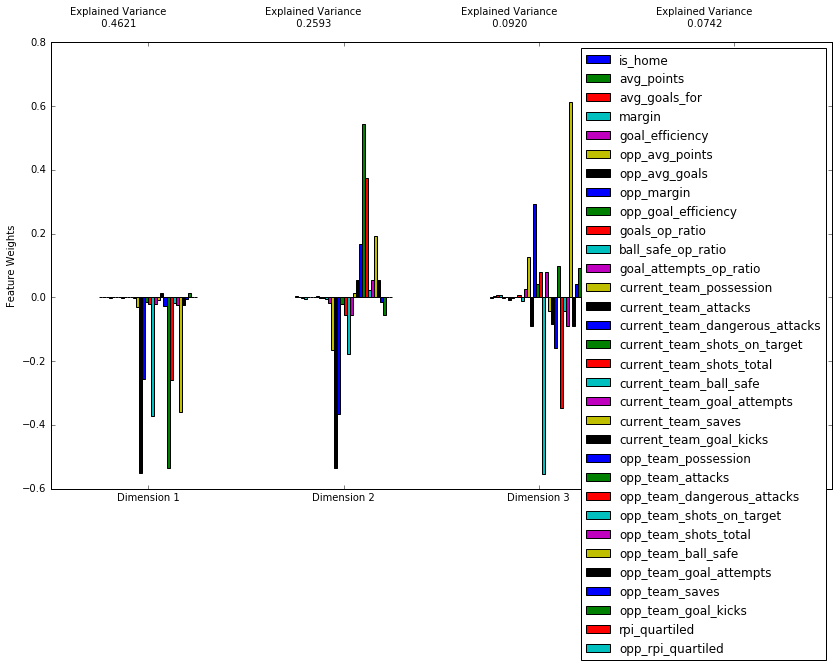

In [13]:
def plot_PCA(data):
    
    pca = PCA(n_components=4)
    pca.fit(data)
    
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    #print(pca_results)
    pca_data = pca.transform(data)
    
    # Create a DataFrame for the reduced data
    pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4'])
    #plot_data = pd.concat([preds, pca_data], axis = 1)
    
    # Scatterplotting the transformed data if it's 2 Dimensions
    """fig, ax = plt.subplots(figsize = (14,8))
    cmap = cm.get_cmap('gist_rainbow')
    
    for i, cluster in plot_data.groupby('converted_goals'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                     color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);"""
    
    return pca, pca_data, pca_results

pca, pca_data, pca_results = plot_PCA(classifier_X)

all_pca_data = pd.concat([classifier_y, pca_data], axis = 1)

print(pca_data.shape)

# Runs models on PCA to see if there is a difference in the results
pca_models = run_features(all_pca_data, [], 'converted_goals', ['log', 'knn', 'gnb', 'randomForest'])

#preds = knn.predict(pca_X)
(pca_y, pca_X) = model_libs._extract_target(all_pca_data, 'converted_goals')

for m in pca_models:
    check_accuracy(m, pca_X)

Cross Validating the SVC model with the PCA data to help prevent overfitting

In [ ]:
pca_svc_model = form_model.build_tuned_model(pca_X, pca_y, 'svc')

In [21]:
prediction_models = form_model.load_models(['knn', 'svc', 'randomForest', 'gmm', 'gnb'])

Success :: Loaded - knn
Success :: Loaded - svc
Success :: Loaded - randomForest
Success :: Loaded - gmm
Success :: Loaded - gnb


### Linear Regression

In [19]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_predict

display(regr_data.head())

regr_data = regr_data.drop(sub_cols + ignore_cols + ['rpi', 'opp_rpi', 'converted_goals'], 1)
(regr_data_y, regr_data_X) = model_libs._extract_target(regr_data, 'goals')
""" Reordering the columns in the data to reflect the rankings """
linear_ranked = rank_columns(regr_data_X, rankings)
lin_regr = linear_model.LinearRegression()

X_train, X_test, y_train, y_test = cross_validation.train_test_split(linear_ranked.iloc[:, 1:17], regr_data_y, test_size=0.2, random_state=42)
lin_regr.fit(X_train, y_train)
#predicted = cross_val_predict(lin_regr, reg_X, reg_y, cv=10)
print('Coefficients: \n', lin_regr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((lin_regr.predict(X_test) - y_test) ** 2))

print(lin_regr.predict(X_test))
display(y_test.head())

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,goal_efficiency,win_percentage,sos,rpi,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,opp_win_percentage,opp_sos,opp_rpi,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_cards,current_team_corner_kicks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_first_half_goals,current_team_sec_half_goals,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_yellow_cards,opp_team_corner_kicks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_first_half_goals,opp_team_sec_half_goals,opp_team_goal_kicks,goals,converted_goals,rpi_quartiled,opp_rpi_quartiled
0,249,21,FC Dallas,33,DC United,2016-03-26 21:30:00,4,3,0,4-2-3-1,2.000000,1.333333,1.666667,-0.333333,-1,0.117647,0.666667,0.619048,0.630952,1.000000,2.000000,0.666667,0.000000,0.714286,0.517544,0.477444,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,2.000000,6.666667,6.666667,11.666667,85.333333,11.666667,1.666667,0.333333,1.000000,5.666667,48.666667,113.666667,45.333333,1.000000,2.333333,5.333333,8.666667,112.333333,8.666667,4.333333,0.666667,1.333333,8.666667,3,1,1.0000,0.0000
1,255,21,FC Dallas,39,Columbus Crew,2016-04-03 01:00:00,5,3,1,4-4-2,2.000000,1.666667,1.666667,0.000000,0,0.333333,0.714286,0.383130,0.465919,0.333333,0.333333,-1.000000,0.000000,0.312500,0.487421,0.407233,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,2.333333,4.666667,5.666667,10.666667,94.666667,10.666667,1.666667,0.666667,1.000000,5.333333,47.666667,110.666667,60.000000,2.333333,4.333333,2.333333,7.666667,108.666667,7.666667,1.666667,0.000000,0.333333,9.000000,1,0,0.3333,0.0000
2,265,21,FC Dallas,32,San Jose Earthquakes,2016-04-10 01:00:00,6,3,1,4-4-2,2.333333,2.000000,0.333333,1.666667,5,0.052632,0.833333,0.452519,0.547723,0.333333,0.666667,-0.333333,0.166667,0.312500,0.441520,0.456140,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,2.000000,3.333333,6.333333,15.000000,95.333333,15.000000,3.000000,0.666667,1.333333,5.666667,54.000000,97.666667,57.000000,0.333333,6.000000,6.333333,10.666667,93.000000,10.666667,2.666667,0.333333,0.333333,9.000000,2,1,0.6666,0.0000
3,272,21,FC Dallas,30,Portland Timbers,2016-04-14 02:30:00,7,3,0,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,1.000000,1.333333,-0.666667,0.285714,0.357143,0.645906,0.573715,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,3,1,0.6666,1.0000
4,282,21,FC Dallas,27,Sporting Kansas City,2016-04-17 23:00:00,7,3,1,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,0.000000,1.333333,-0.666667,0.285714,0.357143,0.490184,0.523888,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,2,1,0.6666,0.6666


('Coefficients: \n', array([ 0.00570921,  0.88690823, -0.02492005,  0.1273794 , -0.01270169,
        0.12452732,  0.00554075,  0.15858556,  0.07372105, -0.04425476,
        0.0009377 , -0.00436708,  0.00994137, -0.01374641,  0.03563341,
        0.44664488]))
Residual sum of squares: 1.36
[ 1.71645538  1.57293654  1.5427924   1.53865904  1.54800309  1.48670046
  1.11838637  1.84176641  1.18842192  1.85253368  1.69340817  1.59228649
  1.04478343  1.67505716  1.34956486  1.17412737  1.5465164   1.51758455
  1.21801087  1.57946281  1.90101608  1.15392558  1.7112434   1.86397461
  1.33449314  1.2929383   1.35813263  1.24037453  1.6371011   1.59186979
  1.3137122   1.87284178  1.07036478  1.19129402  1.71621183  1.16204487
  1.5758938   1.45038736  1.16880143  1.86919315  1.58624325  1.86268248
  1.16784225  1.68385139  1.76141194  1.14129228  1.13906891  1.35981624
  1.3600633   1.03315499  1.39612473  1.52491528  1.59721     1.43616545
  1.81791354  1.19053388  1.46476594  1.02139828  1.04

350    3
377    0
163    0
609    0
132    0
Name: goals, dtype: float64

In [16]:
upcoming_matches, match_details = predict_matches.get_upcoming_matches()
upcoming_matches.to_csv('upcoming_matches.csv')
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
upcoming_data = predict_matches.predictions(upcoming_matches)
#upcoming_data.to_csv('upcoming_data.csv')
display(upcoming_data.head())

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,goal_efficiency,win_percentage,sos,rpi,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,opp_win_percentage,opp_sos,opp_rpi,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_cards,current_team_corner_kicks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_first_half_goals,current_team_sec_half_goals,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_yellow_cards,opp_team_corner_kicks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_first_half_goals,opp_team_sec_half_goals,opp_team_goal_kicks,goals,points
0,900,21,FC Dallas,23,Real Salt Lake,2016-09-25 01:30:00,28,3,0,4-2-3-1,1.333333,1.666667,1.333333,0.333333,1,0.133333,0.433333,0.531008,0.506589,1.333333,2.000000,-0.333333,0.222222,0.500000,0.577770,0.474994,0.833333,0.723404,1.392857,45.000000,100.333333,54.333333,2.666667,6.333333,7.000000,13.000000,79.333333,13.000000,1.333333,1.000000,0.666667,6.666667,62.000000,101.333333,48.666667,1.666667,5.000000,4.333333,9.333333,109.666667,9.333333,6.000000,0.333333,1.666667,12.666667,5,4
1,896,22,Colorado Rapids,28,Vancouver Whitecaps FC,2016-09-24 23:00:00,28,3,0,4-2-3-1,1.333333,0.333333,0.666667,-0.333333,-1,0.000000,0.566667,0.397186,0.439556,0.666667,0.333333,-0.666667,0.000000,0.357143,0.503760,0.471570,1.000000,1.000000,1.043478,53.000000,98.000000,47.333333,3.666667,3.000000,2.666667,8.000000,93.333333,8.000000,4.000000,0.000000,0.333333,8.000000,48.000000,95.333333,48.000000,1.666667,4.666667,3.333333,7.666667,93.333333,7.666667,2.000000,0.333333,0.000000,9.333333,1,4
2,900,23,Real Salt Lake,21,FC Dallas,2016-09-25 01:30:00,28,3,1,4-3-3,0.333333,1.000000,1.666667,-0.666667,-2,0.000000,0.166667,0.439394,0.371212,1.333333,1.666667,-0.333333,0.250000,0.500000,0.552513,0.522718,0.600000,1.062963,1.545455,58.666667,110.333333,62.000000,3.000000,3.333333,4.000000,11.333333,95.666667,11.333333,1.666667,0.000000,1.000000,6.000000,50.666667,87.333333,34.666667,3.000000,4.666667,4.000000,7.333333,90.000000,7.333333,2.666667,1.000000,0.666667,9.000000,3,1
3,894,24,New York City FC,40,Chicago Fire,2016-09-24 00:00:00,28,3,1,4-3-3,1.333333,2.000000,2.333333,-0.333333,-1,0.222222,0.500000,0.480556,0.485417,1.333333,1.666667,0.333333,0.133333,0.433333,0.411610,0.417041,1.200000,1.382353,0.717949,62.000000,101.333333,48.666667,1.666667,5.000000,4.333333,9.333333,109.666667,9.333333,6.000000,0.333333,1.666667,12.666667,45.000000,100.333333,54.333333,2.666667,6.333333,7.000000,13.000000,79.333333,13.000000,1.333333,1.000000,0.666667,6.666667,6,4
4,895,25,Philadelphia Union,34,Toronto FC,2016-09-24 21:00:00,28,3,0,4-2-3-1,0.333333,0.666667,2.000000,-1.333333,-4,0.076923,0.192308,0.533592,0.448271,2.000000,1.333333,0.000000,0.105263,0.666667,0.441951,0.456463,0.500000,1.124514,0.885714,47.000000,105.666667,44.666667,1.666667,5.000000,5.333333,10.333333,96.333333,10.333333,3.666667,0.333333,0.333333,8.000000,50.333333,97.666667,51.000000,1.666667,4.333333,4.000000,11.666667,85.666667,11.666667,5.666667,0.333333,1.000000,7.333333,2,1


In [17]:
""" Need to format the data the same way we did on the raw data """
formatted_upcoming_data = upcoming_data.drop('points', 1)

#formatted_upcoming_data['converted_goals'] = formatted_upcoming_data.apply(lambda row: model_libs.set_group(row['goals']), axis=1)

classifier_upcoming_data = model_libs.convert_sos_rpi(leagues, formatted_upcoming_data, teams)

classifier_upcoming_data = classifier_upcoming_data.drop(sub_cols + ignore_cols + ['goals'] + ['rpi', 'opp_rpi'], 1)
display(classifier_upcoming_data.head())

,is_home,avg_points,avg_goals_for,margin,goal_efficiency,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,rpi_quartiled,opp_rpi_quartiled
0,0,1.333333,1.666667,0.333333,0.133333,1.333333,2.000000,-0.333333,0.222222,0.833333,0.723404,1.392857,45.000000,100.333333,54.333333,7.000000,13.000000,79.333333,13.000000,1.333333,6.666667,62.000000,101.333333,48.666667,4.333333,9.333333,109.666667,9.333333,6.000000,12.666667,1.0000,0.6666
1,0,1.333333,0.333333,-0.333333,0.000000,0.666667,0.333333,-0.666667,0.000000,1.000000,1.000000,1.043478,53.000000,98.000000,47.333333,2.666667,8.000000,93.333333,8.000000,4.000000,8.000000,48.000000,95.333333,48.000000,3.333333,7.666667,93.333333,7.666667,2.000000,9.333333,0.3333,0.6666
2,1,0.333333,1.000000,-0.666667,0.000000,1.333333,1.666667,-0.333333,0.250000,0.600000,1.062963,1.545455,58.666667,110.333333,62.000000,4.000000,11.333333,95.666667,11.333333,1.666667,6.000000,50.666667,87.333333,34.666667,4.000000,7.333333,90.000000,7.333333,2.666667,9.000000,0.0000,1.0000
3,1,1.333333,2.000000,-0.333333,0.222222,1.333333,1.666667,0.333333,0.133333,1.200000,1.382353,0.717949,62.000000,101.333333,48.666667,4.333333,9.333333,109.666667,9.333333,6.000000,12.666667,45.000000,100.333333,54.333333,7.000000,13.000000,79.333333,13.000000,1.333333,6.666667,0.6666,0.0000
4,0,0.333333,0.666667,-1.333333,0.076923,2.000000,1.333333,0.000000,0.105263,0.500000,1.124514,0.885714,47.000000,105.666667,44.666667,5.333333,10.333333,96.333333,10.333333,3.666667,8.000000,50.333333,97.666667,51.000000,4.000000,11.666667,85.666667,11.666667,5.666667,7.333333,0.3333,0.6666


,goal_attempts_op_ratio,current_team_dangerous_attacks,ball_safe_op_ratio,current_team_shots_on_target,opp_goal_efficiency,goals_op_ratio,avg_goals_for,opp_team_ball_safe,opp_avg_points,margin,opp_avg_goals,opp_team_possession,current_team_ball_safe,opp_team_shots_total,opp_team_shots_on_target,current_team_possession,is_home,rpi_quartiled,avg_points,opp_margin,opp_team_attacks,opp_team_dangerous_attacks,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,current_team_goal_kicks,opp_rpi_quartiled,current_team_saves,current_team_shots_total,current_team_attacks,goal_efficiency,current_team_goal_attempts
0,1.392857,54.333333,0.723404,7.000000,0.222222,0.833333,1.666667,109.666667,1.333333,0.333333,2.000000,62.000000,79.333333,9.333333,4.333333,45.000000,0,1.0000,1.333333,-0.333333,101.333333,48.666667,9.333333,6.000000,12.666667,6.666667,0.6666,1.333333,13.000000,100.333333,0.133333,13.000000
1,1.043478,47.333333,1.000000,2.666667,0.000000,1.000000,0.333333,93.333333,0.666667,-0.333333,0.333333,48.000000,93.333333,7.666667,3.333333,53.000000,0,0.3333,1.333333,-0.666667,95.333333,48.000000,7.666667,2.000000,9.333333,8.000000,0.6666,4.000000,8.000000,98.000000,0.000000,8.000000
2,1.545455,62.000000,1.062963,4.000000,0.250000,0.600000,1.000000,90.000000,1.333333,-0.666667,1.666667,50.666667,95.666667,7.333333,4.000000,58.666667,1,0.0000,0.333333,-0.333333,87.333333,34.666667,7.333333,2.666667,9.000000,6.000000,1.0000,1.666667,11.333333,110.333333,0.000000,11.333333
3,0.717949,48.666667,1.382353,4.333333,0.133333,1.200000,2.000000,79.333333,1.333333,-0.333333,1.666667,45.000000,109.666667,13.000000,7.000000,62.000000,1,0.6666,1.333333,0.333333,100.333333,54.333333,13.000000,1.333333,6.666667,12.666667,0.0000,6.000000,9.333333,101.333333,0.222222,9.333333
4,0.885714,44.666667,1.124514,5.333333,0.105263,0.500000,0.666667,85.666667,2.000000,-1.333333,1.333333,50.333333,96.333333,11.666667,4.000000,47.000000,0,0.3333,0.333333,0.000000,97.666667,51.000000,11.666667,5.666667,7.333333,8.000000,0.6666,3.666667,10.333333,105.666667,0.076923,10.333333


[0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 3 1 1 2 1 1 2 1 1 1 1 1 2 1 2 1 1 1 3 3 3 1 1 1 1 1 1 1 3 1 3 1 1 2
 1 3 1 3 1 3 1 1 2 2 2 1 1 1 1 2 3 1 3 2 1 1 1 2 1 1 2 1 1 1 2 1 3 1 2 1 2
 1 1 1 3 1 1 1 2 1 3 1 2 1 2 2 2 1 2 2 2 1 3 1 1]
[1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1]


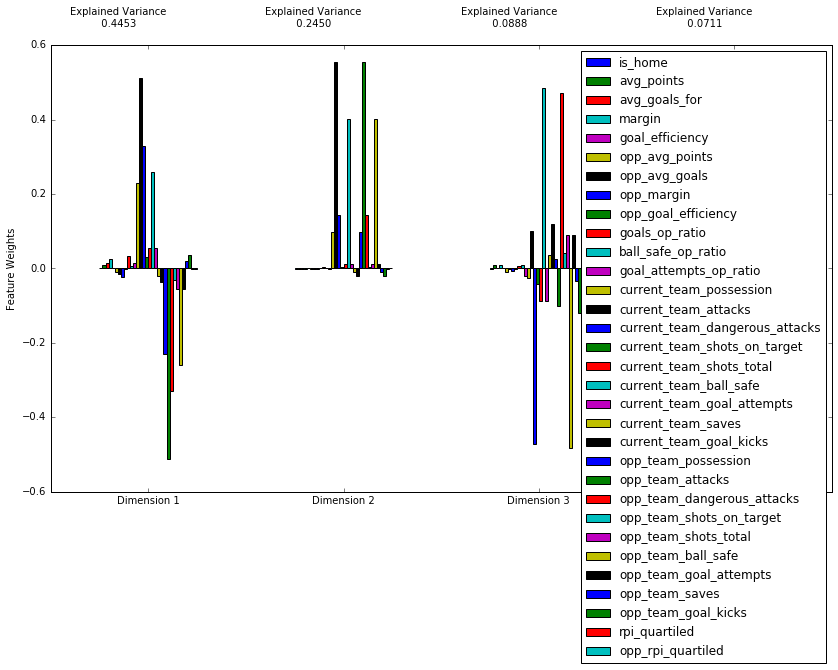

In [22]:
""" Models we'll use to predict on upcoming matches """
# pca_svc_model, knn_model, random_forest_model

# This is all the X values
classifier_upcoming_data

""" Reordering the columns in the data to reflect the rankings """
upcoming_ranked = rank_columns(classifier_upcoming_data, rankings)
display(upcoming_ranked.head())

rf_preds = prediction_models[2].predict(upcoming_ranked.iloc[:, 1:17])
print(rf_preds)
knn_preds = prediction_models[0].predict(upcoming_ranked.iloc[:, 1:12])
print(knn_preds)
upcoming_pca, upcoming_pca_data, upcoming_pca_results = plot_PCA(classifier_upcoming_data)

svc_preds = prediction_models[1].predict(upcoming_pca_data)
print(svc_preds)

gmm_preds = prediction_models[3].predict(upcoming_ranked.iloc[:, 1:17])
print(gmm_preds)

gnb_preds = prediction_models[4].predict(upcoming_ranked.iloc[:, 1:17])
print(gnb_preds)

linear_preds = lin_regr.predict(upcoming_ranked.iloc[:, 1:17])
print(linear_preds)


In [25]:
columns = ['team_name', 'opp_name', 'scheduled']
# Remove all columns except the ones above
upcoming_matches = upcoming_data[columns]

# Add predictions to the end of that DF
results = pd.DataFrame({'KNN': knn_preds, 'RandomForest': rf_preds, 'SVC': svc_preds, 'GMM': gmm_preds, 'GNB': gnb_preds, 'Linear': linear_preds})
upcoming_matches = pd.concat([upcoming_matches, results], axis = 1)
reordered_matches = pd.DataFrame([])

for rows in upcoming_matches.iterrows():
    for i in upcoming_matches['team_name']:
        if rows[1]['opp_name'] == i:
            reordered_matches = reordered_matches.append(rows[1])
            reordered_matches = reordered_matches.append(upcoming_matches[upcoming_matches['team_name'].isin([i])])

reordered_matches = reordered_matches.drop_duplicates() 
columns = ['scheduled', 'team_name', 'opp_name', 'KNN', 'RandomForest', 'SVC', 'GMM', 'GNB', 'Linear']
reordered_matches = reordered_matches[columns]
reordered_matches.to_csv('predictions_new.csv')
print('Prediction CSV saved')

Prediction CSV saved
